# Cross-Model Evaluation

Comparitive evaluation of the different models trained on different features for Raga Identification.

In [2]:
import numpy as np
from tensorflow import keras
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

### Load Datasets and models

In [3]:
# Load datasets
Xa = np.load('../dataset/counts.npy')           # Vadi-Samvadi (pitch histogram)
Xb = np.load('../dataset/slopes.npy')           # Arohana-Avarohana
Xc = np.load('../dataset/stds.npy')             # Gamaka
y = np.load('../dataset/labels.npy')
classes = np.load('../dataset/mappings.npy')

# Load test split indices to ensure consistent evaluation
from sklearn.model_selection import train_test_split

_, Xa_temp, _, Xb_temp, _, Xc_temp, _, y_temp = train_test_split(Xa, Xb, Xc, y, test_size=0.3, random_state=42)
_, Xa_test, _, Xb_test, _, Xc_test, _, y_test = train_test_split(Xa_temp, Xb_temp, Xc_temp, y_temp, test_size=0.5, random_state=42)

# Load all trained models
models = {
    'Vadi-Samvadi': keras.models.load_model('../models/vadi_samvadi_model.keras'),
    'Arohana-Avarohana': keras.models.load_model('../models/arohana_avarohana_model.keras'),
    'Gamaka': keras.models.load_model('../models/gamaka_model.keras'),
    'Combined': keras.models.load_model('../models/combined_model.keras')
}

I0000 00:00:1744372583.037218   11019 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2051 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### Cross-Model Performance Comparison

In [5]:
# Evaluate performance metrics for each model
results = []

# Single feature models
model_inputs = {
    'Vadi-Samvadi': Xa_test,
    'Arohana-Avarohana': Xb_test,
    'Gamaka': Xc_test
}

# Initialize dataframe to store per-class metrics
per_class_metrics = {}

# Evaluate each model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} model...")
    
    # Get predictions based on model type
    if model_name == 'Combined':
        y_pred = model.predict([Xa_test, Xb_test, Xc_test])
    else:
        X_test = model_inputs[model_name]
        y_pred = model.predict(X_test)
    
    # Convert to class indices
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    acc = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
    
    # Get per-class report
    report = classification_report(y_true_classes, y_pred_classes, 
                                  target_names=classes, output_dict=True)
    
    # Store per-class F1 scores
    for raga in classes:
        if raga not in per_class_metrics:
            per_class_metrics[raga] = {}
        per_class_metrics[raga][model_name] = report[raga]['f1-score']
    
    # Store overall results
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'F1 Score': f1
    })
    
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

# Convert results to dataframe
results_df = pd.DataFrame(results)
print("\nOverall Model Performance:")
print(results_df)


Evaluating Vadi-Samvadi model...
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7408, F1 Score: 0.7263

Evaluating Arohana-Avarohana model...
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.2632, F1 Score: 0.2432

Evaluating Gamaka model...
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.2761, F1 Score: 0.2521

Evaluating Combined model...
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.6847, F1 Score: 0.6641

Overall Model Performance:
               Model  Accuracy  F1 Score
0       Vadi-Samvadi  0.740809  0.726339
1  Arohana-Avarohana  0.263235  0.243165
2             Gamaka  0.276103  0.252061
3           Combined  0.684743  0.664065


<Figure size 1200x600 with 0 Axes>

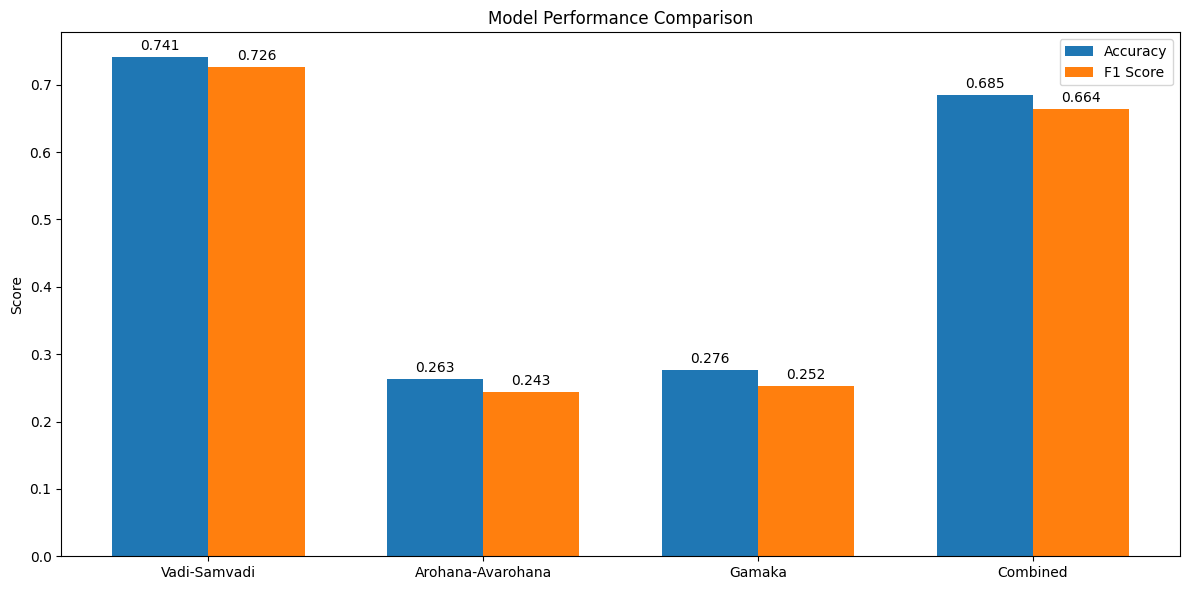

In [ ]:
# Visualize overall performance comparison
plt.figure(figsize=(12, 6))

# Plot accuracy and F1 score for each model
x = np.arange(len(results_df))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, results_df['Accuracy'], width, label='Accuracy')
rects2 = ax.bar(x + width/2, results_df['F1 Score'], width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'])
ax.legend()

# Add values on top of bars
for rect in rects1:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../plots/model_performance_comparison.png', dpi=300)
plt.show()

### Per-Raga Model Performances

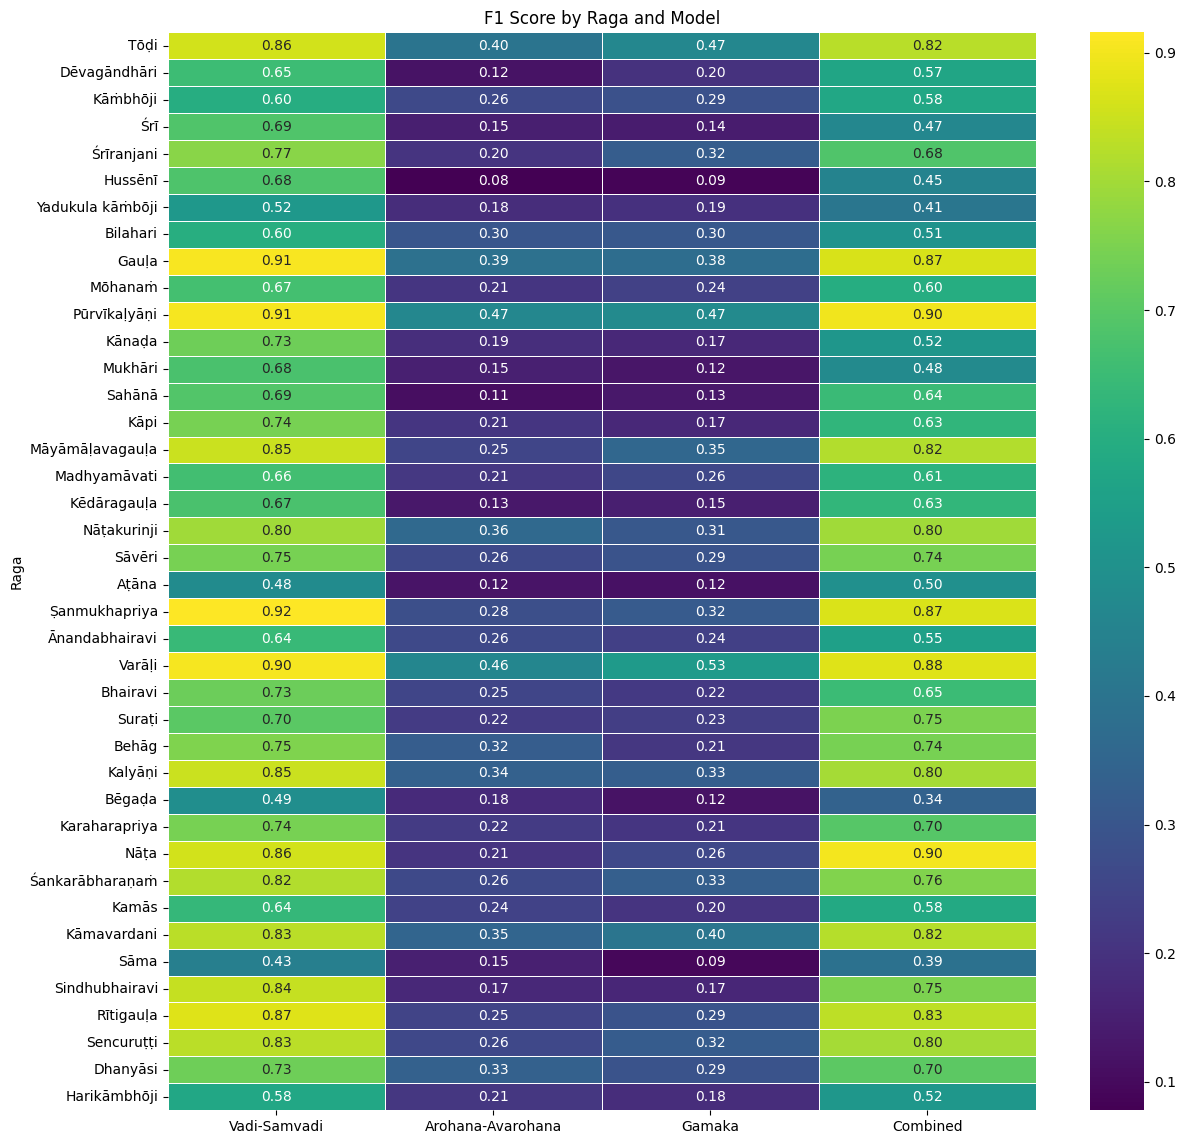

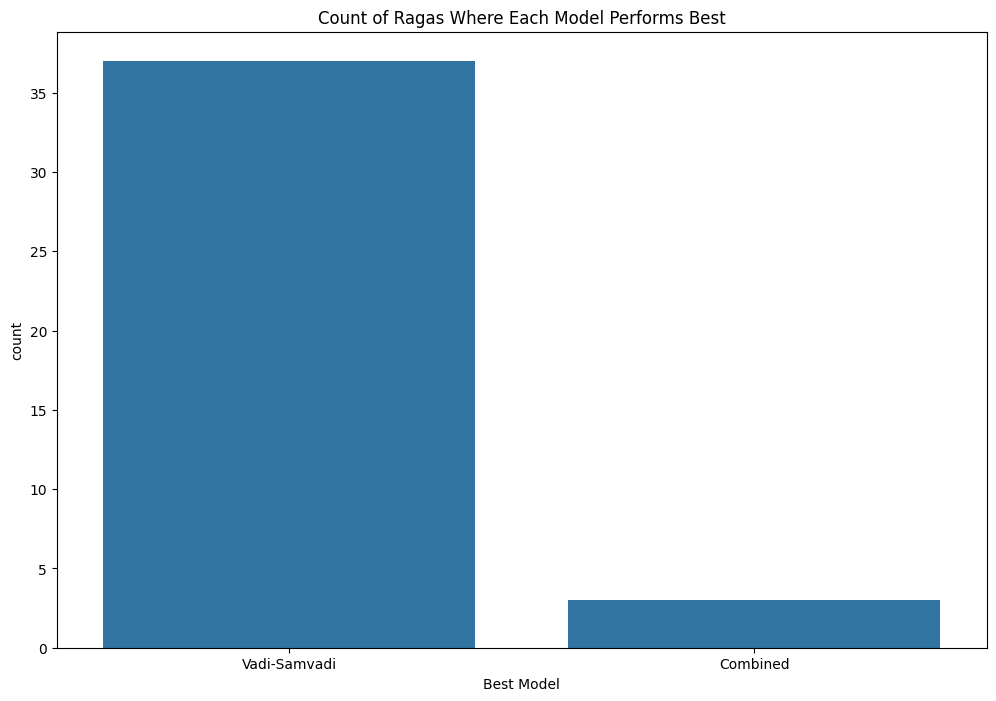

In [7]:
# Create dataframe for per-class performance
per_class_df = pd.DataFrame(per_class_metrics).T
per_class_df = per_class_df.reset_index().rename(columns={'index': 'Raga'})

# Melt the dataframe for easier plotting with seaborn
melted_df = pd.melt(per_class_df, id_vars=['Raga'], var_name='Model', value_name='F1 Score')

# Plot heatmap of per-class F1 scores across models
plt.figure(figsize=(14, 14))
heatmap_df = per_class_df.set_index('Raga')
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('F1 Score by Raga and Model')
plt.savefig('../plots/f1_score_heatmap.png', dpi=300)
plt.show()

# Plot best model for each raga
best_models = per_class_df.set_index('Raga').idxmax(axis=1).reset_index()
best_models.columns = ['Raga', 'Best Model']

plt.figure(figsize=(12, 8))
sns.countplot(x='Best Model', data=best_models)
plt.title('Count of Ragas Where Each Model Performs Best')
plt.savefig('../plots/best_model_count.png', dpi=300)
plt.show()

**Most Confused Ragas**

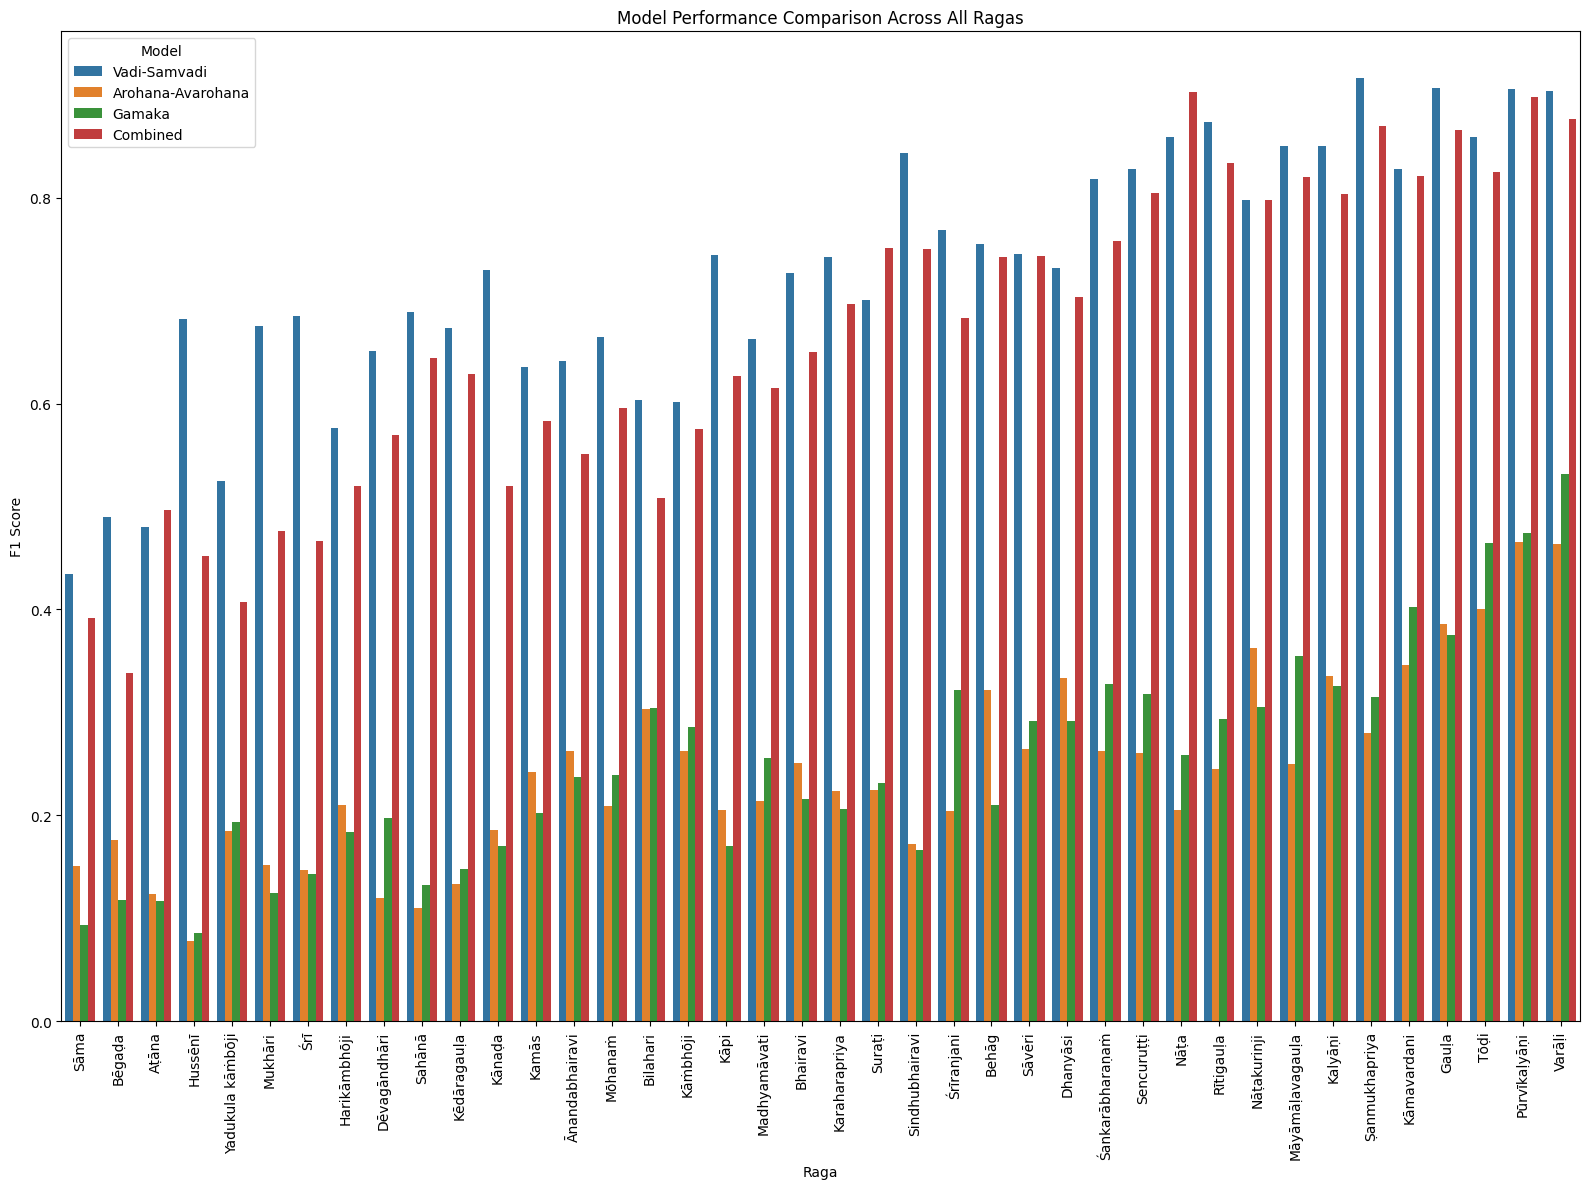

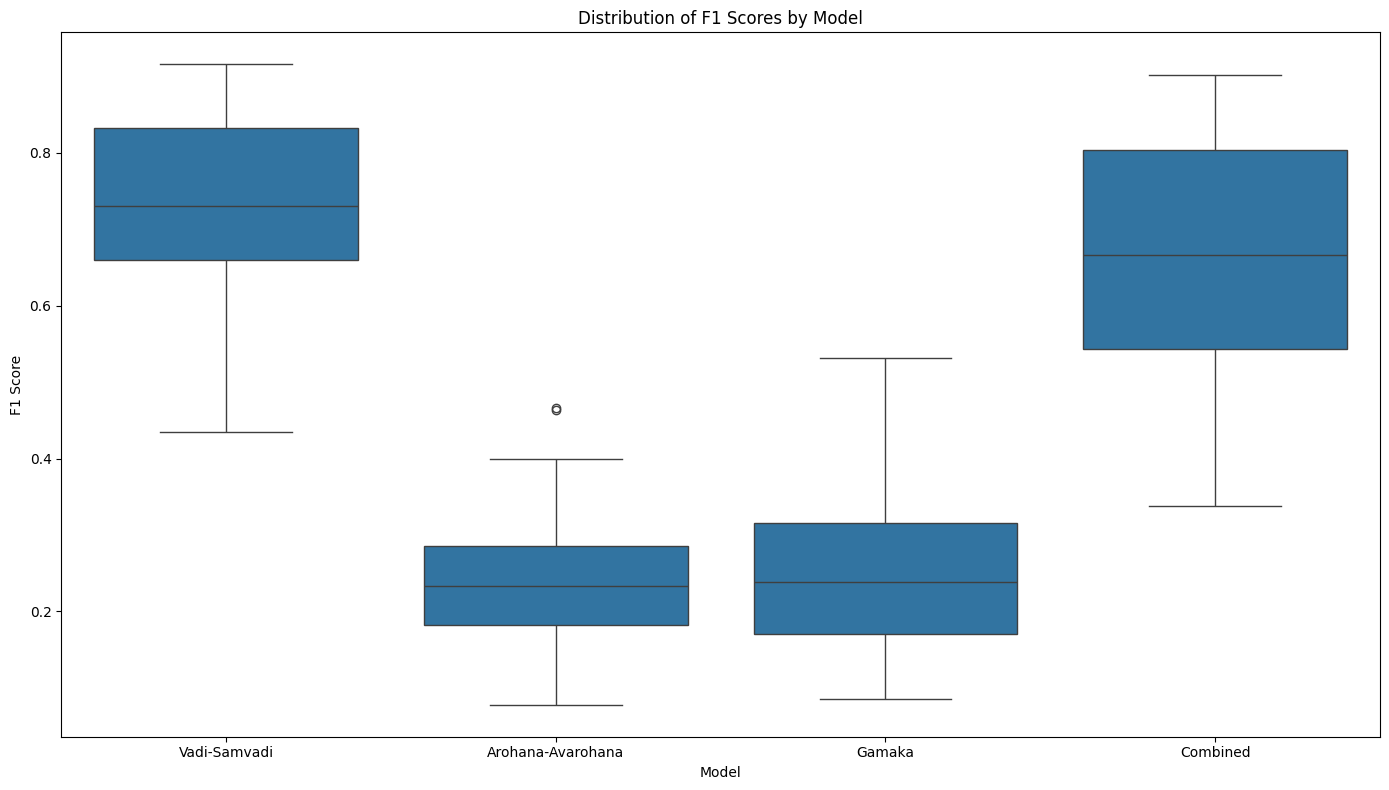


Top 5 ragas for each model:

Vadi-Samvadi:
  1. Ṣanmukhapriya (F1: 0.916)
  2. Gauḷa (F1: 0.906)
  3. Pūrvīkaḷyāṇi (F1: 0.906)
  4. Varāḷi (F1: 0.903)
  5. Rītigauḷa (F1: 0.874)

Arohana-Avarohana:
  1. Pūrvīkaḷyāṇi (F1: 0.466)
  2. Varāḷi (F1: 0.464)
  3. Tōḍi (F1: 0.400)
  4. Gauḷa (F1: 0.386)
  5. Nāṭakurinji (F1: 0.362)

Gamaka:
  1. Varāḷi (F1: 0.531)
  2. Pūrvīkaḷyāṇi (F1: 0.475)
  3. Tōḍi (F1: 0.465)
  4. Kāmavardani (F1: 0.403)
  5. Gauḷa (F1: 0.375)

Combined:
  1. Nāṭa (F1: 0.902)
  2. Pūrvīkaḷyāṇi (F1: 0.898)
  3. Varāḷi (F1: 0.876)
  4. Ṣanmukhapriya (F1: 0.870)
  5. Gauḷa (F1: 0.866)


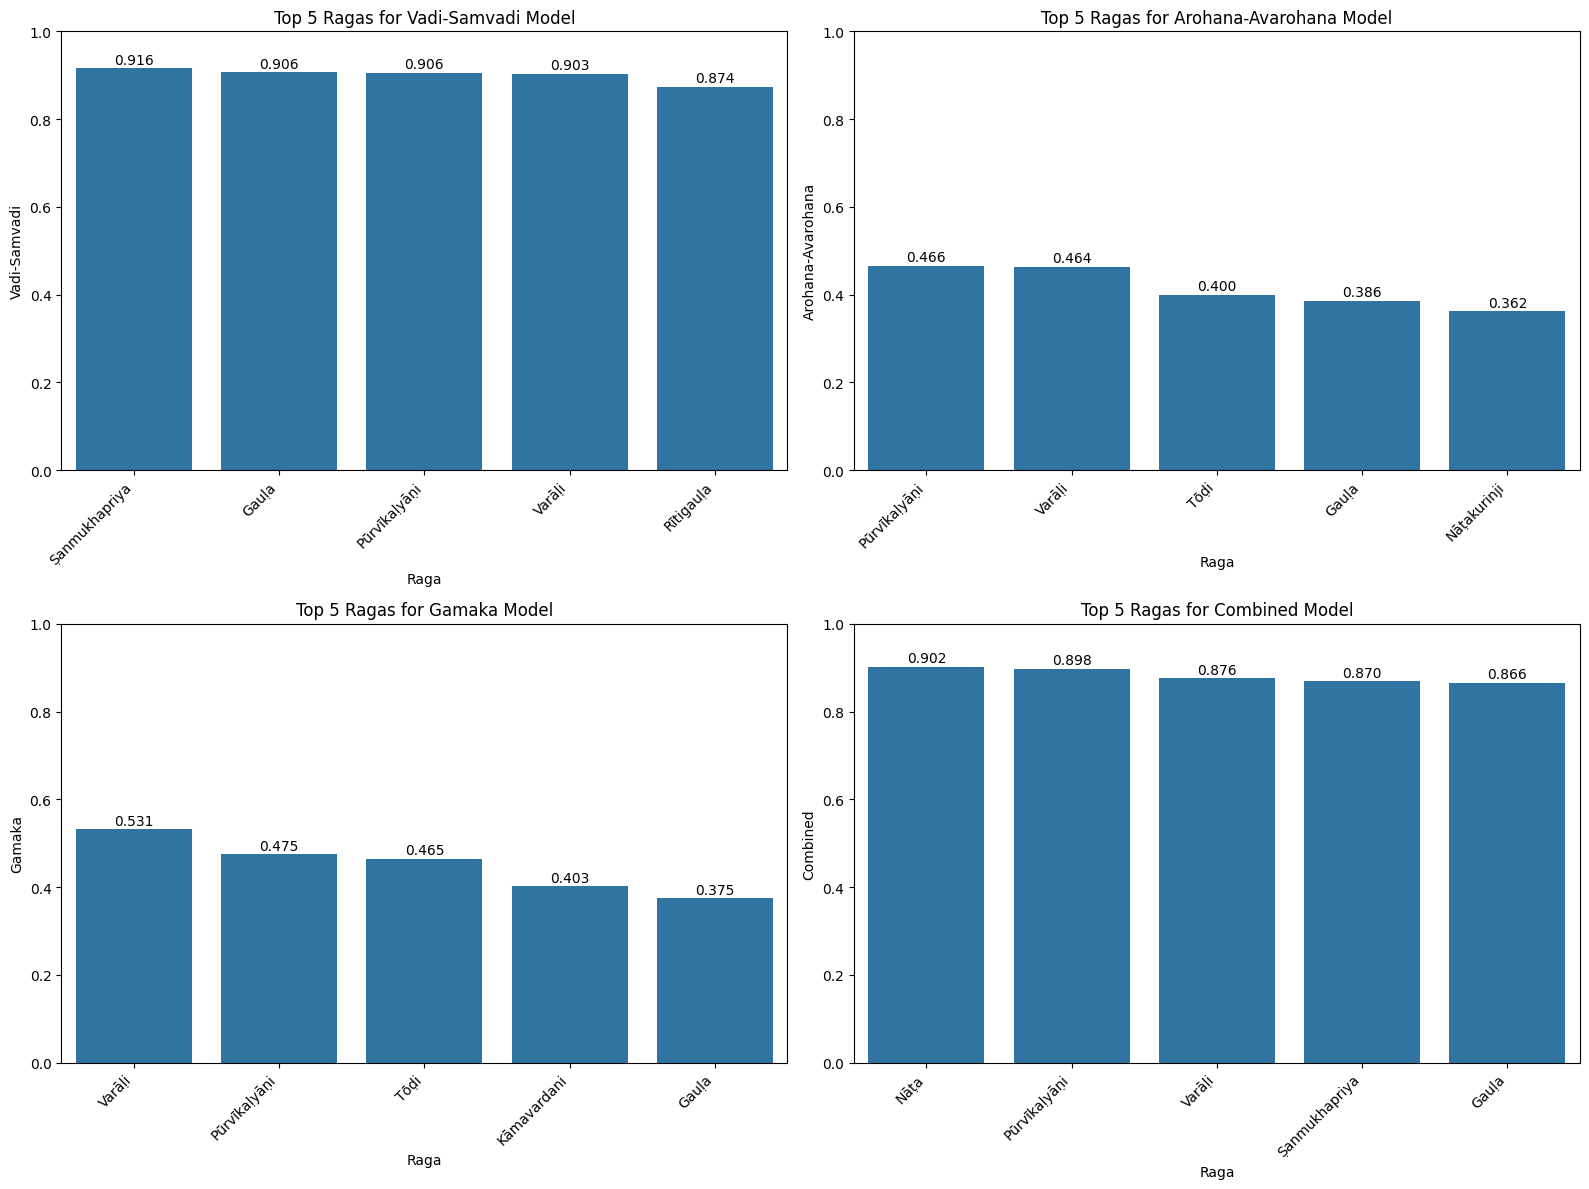

In [14]:
# Compare model performances across all ragas
model_comparison = []

# Get sorted list of ragas by F1 score for better visualization
avg_f1_by_raga = per_class_df.iloc[:, 1:].mean(axis=1)
sorted_ragas = per_class_df.loc[avg_f1_by_raga.sort_values().index, 'Raga'].tolist()

# Create comparison data for all models across all ragas
for model_name in per_class_df.columns[1:]:  # Skip 'Raga' column
    for raga in sorted_ragas:
        f1_score = per_class_df.loc[per_class_df['Raga'] == raga, model_name].values[0]
        model_comparison.append({
            'Model': model_name,
            'Raga': raga,
            'F1 Score': f1_score
        })

# Convert to DataFrame
model_comparison_df = pd.DataFrame(model_comparison)

# Plot model comparison for all ragas
plt.figure(figsize=(16, 12))
sns.barplot(x='Raga', y='F1 Score', hue='Model', data=model_comparison_df)
plt.xticks(rotation=90)
plt.title('Model Performance Comparison Across All Ragas')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('../plots/model_comparison_by_raga.png', dpi=300)
plt.show()

# Plot distribution of F1 scores for each model
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='F1 Score', data=model_comparison_df)
plt.title('Distribution of F1 Scores by Model')
plt.tight_layout()
plt.savefig('../plots/f1_score_distribution.png', dpi=300)
plt.show()

# Find where each model performs best
best_ragas_by_model = {}
for model in per_class_df.columns[1:]:
    # Get top 5 ragas for this model
    top_ragas = per_class_df.sort_values(by=model, ascending=False).head(5)['Raga'].tolist()
    best_ragas_by_model[model] = top_ragas

# Print best ragas for each model
print("\nTop 5 ragas for each model:")
for model, ragas in best_ragas_by_model.items():
    print(f"\n{model}:")
    for i, raga in enumerate(ragas, 1):
        f1 = per_class_df.loc[per_class_df['Raga'] == raga, model].values[0]
        print(f"  {i}. {raga} (F1: {f1:.3f})")

# Plot top 5 ragas for each model
plt.figure(figsize=(16, 12))
for i, (model, ragas) in enumerate(best_ragas_by_model.items()):
    plt.subplot(2, 2, i+1)
    
    # Get F1 scores for these ragas
    model_data = per_class_df.loc[per_class_df['Raga'].isin(ragas), ['Raga', model]]
    model_data = model_data.sort_values(by=model, ascending=False)
    
    sns.barplot(x='Raga', y=model, data=model_data)
    plt.title(f'Top 5 Ragas for {model} Model')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    
    # Add values on bars
    for j, v in enumerate(model_data[model]):
        plt.text(j, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.savefig('../plots/top_ragas_by_model.png', dpi=300)
plt.show()


Analyzing confused pairs for Vadi-Samvadi model...
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Top 10 most confused raga pairs for Vadi-Samvadi model:
  Harikāmbhōji → Kāṁbhōji: 47 instances (25.00% error rate)
  Bilahari → Kāṁbhōji: 21 instances (16.80% error rate)
  Bhairavi → Mukhāri: 20 instances (8.93% error rate)
  Bēgaḍa → Kāṁbhōji: 20 instances (16.67% error rate)
  Tōḍi → Dhanyāsi: 18 instances (5.77% error rate)

Analyzing confused pairs for Arohana-Avarohana model...
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Top 10 most confused raga pairs for Arohana-Avarohana model:
  Harikāmbhōji → Kāṁbhōji: 26 instances (13.83% error rate)
  Mōhanaṁ → Kāṁbhōji: 24 instances (11.32% error rate)
  Śankarābharaṇaṁ → Bilahari: 23 instances (9.83% error rate)
  Bhairavi → Tōḍi: 22 instances (9.82% error rate)
  Kānaḍa → Karaharapriya: 21 instances (14.48% error rate)

Analyzing confused pairs for Gamaka model...
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Top 10 most confused raga pairs for Gamaka 

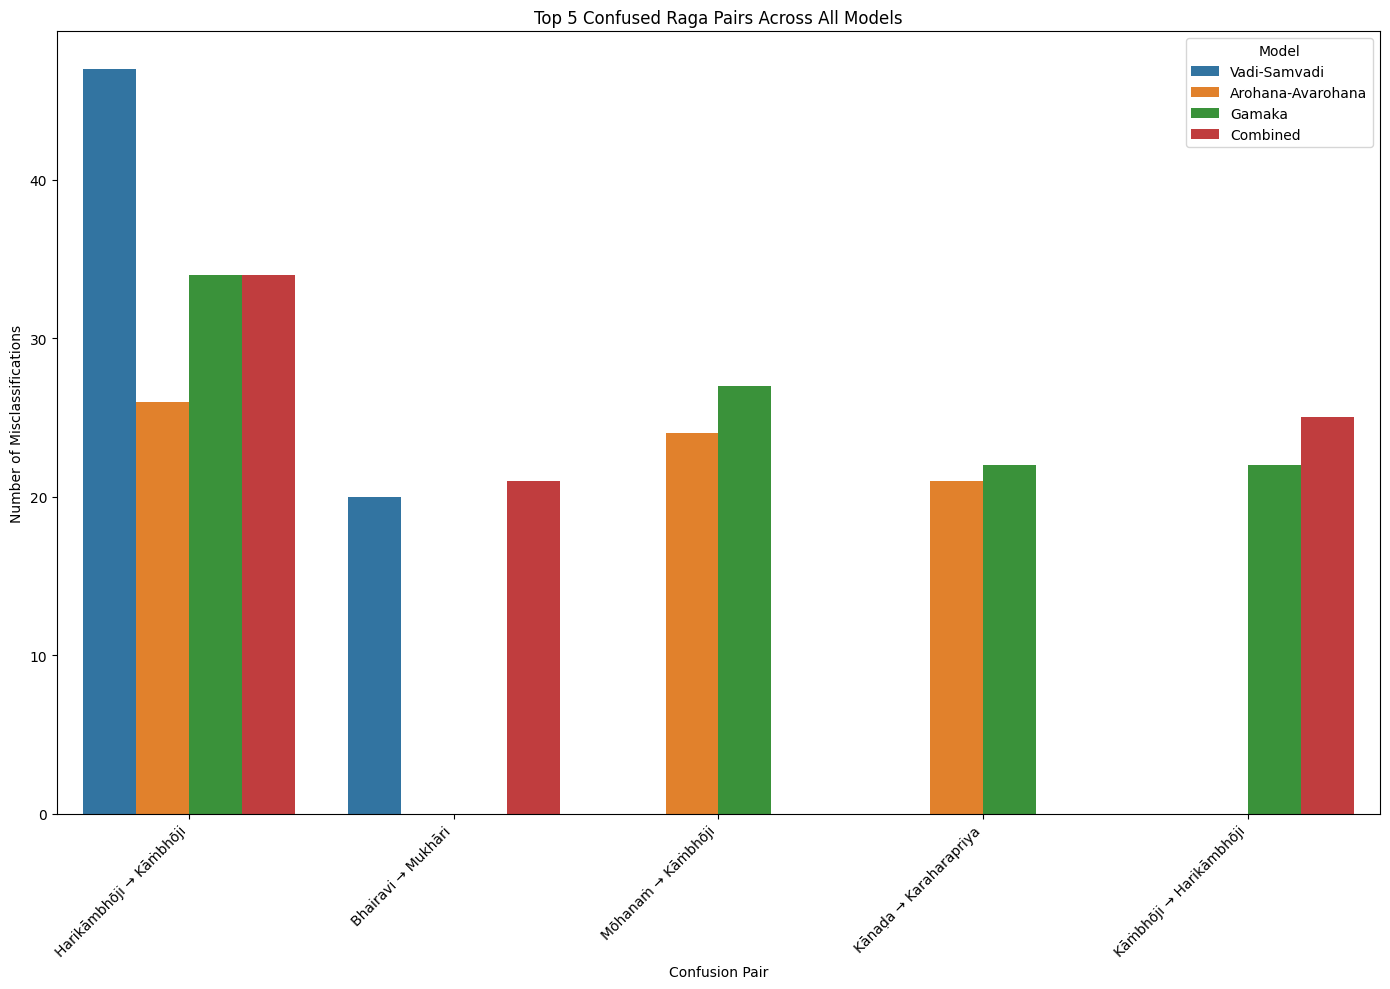

In [21]:
# Identify most commonly confused raga pairs for each model
confused_pairs_by_model = {}

for model_name, model in models.items():
    print(f"\nAnalyzing confused pairs for {model_name} model...")
    
    # Get predictions
    if model_name == 'Combined':
        y_pred = model.predict([Xa_test, Xb_test, Xc_test])
    else:
        X_test = model_inputs[model_name]
        y_pred = model.predict(X_test)
    
    # Convert to class indices
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    # Find confusion pairs
    confusion_pairs = []
    for i in range(len(classes)):
        for j in range(len(classes)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append({
                    'True Raga': classes[i],
                    'Predicted Raga': classes[j],
                    'Count': cm[i, j],
                    'Error Rate': cm[i, j] / cm[i].sum() if cm[i].sum() > 0 else 0
                })
    
    # Convert to DataFrame and sort
    confusion_df = pd.DataFrame(confusion_pairs)
    confusion_df = confusion_df.sort_values('Count', ascending=False).head(5)
    confused_pairs_by_model[model_name] = confusion_df
    
    # Print top confusions
    print(f"Top 10 most confused raga pairs for {model_name} model:")
    for idx, row in confusion_df.iterrows():
        print(f"  {row['True Raga']} → {row['Predicted Raga']}: {row['Count']} instances ({row['Error Rate']:.2%} error rate)")
    

# Create a visualization comparing the top 3 confused pairs across all models
common_confusions = {}

# Find the most frequent confusions across all models
all_confusions = []
for model_name, conf_df in confused_pairs_by_model.items():
    for _, row in conf_df.iterrows():
        confusion_key = f"{row['True Raga']} → {row['Predicted Raga']}"
        all_confusions.append({
            'Confusion': confusion_key,
            'Model': model_name,
            'Count': row['Count'],
            'Error Rate': row['Error Rate']
        })

all_conf_df = pd.DataFrame(all_confusions)

# Get top 5 most common confusions across all models
top_confusions = all_conf_df.groupby('Confusion')['Count'].sum().sort_values(ascending=False).head(5).index.tolist()

# Filter data for these top confusions
top_conf_data = all_conf_df[all_conf_df['Confusion'].isin(top_confusions)]

# Plot comparison
plt.figure(figsize=(14, 10))
sns.barplot(x='Confusion', y='Count', hue='Model', data=top_conf_data)
plt.title('Top 5 Confused Raga Pairs Across All Models')
plt.xlabel('Confusion Pair')
plt.ylabel('Number of Misclassifications')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('../plots/top_confusions_across_models.png', dpi=300)
plt.show()
